In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from iopath.common.file_io import PathManager
from iopath.fb.manifold import ManifoldPathHandler

import logging

from iopath.fb.manifold import logger as manifold_logger
manifold_logger.setLevel(logging.WARN)

pathmgr = PathManager()
pathmgr.register_handler(ManifoldPathHandler())
from tqdm import tqdm

sys.path.insert(0, "fbcode/ar_sharing/body_tracking_3d/models/hmr/")

pathmgr = PathManager()
pathmgr.register_handler(ManifoldPathHandler(), allow_override=True)

%load_ext autoreload
%autoreload 2

I1017 070839.820 font_manager.py:1349] generated new fontManager


I1017 070840.385 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I1017 070840.387 _utils_internal.py:188] NCCL_DEBUG is INFO from /etc/nccl.conf


I1017 070843.208 parsh_logger.py:29] %autoreload 2 was called with 


In [2]:
from src.functional import smpl
from src.models.seq_optim import SeqModel

from src.utils.eval_utils import (
    batch_compute_similarity_transform_torch,
    compute_error_accel,
)

/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/110b607930331a92/ar_sharing/body_tracking_3d/models/hmr/__bento_kernel_body_tracking__/bento_kernel_body_tracking#link-tree/chumpy/ch_ops.py:85: SyntaxWarning:

"is" with a literal. Did you mean "=="?



In [3]:
device = "cuda:0"
smpl_model = smpl.get_smpl_model("h36m", device=device)
faces = smpl_model.faces.astype(int)

In [35]:
m2mm = 1000
torch.set_grad_enabled(False)

exps = ["init", "mix", "smoothing", "flow2d"]

mpjpe_arr = {exp:[] for exp in exps}
accel_joints_err_arr = {exp:[] for exp in exps}

mpjpe_arr_per_seq = {exp:[] for exp in exps}
accel_joints_err_arr_per_seq = {exp:[] for exp in exps}

In [36]:
for exp in exps:
    for i in tqdm(range(253)):
        seqOpt = SeqModel(
            seq_path=f"/tmp/len128/seq_{i:03d}.pth",  ## manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests
        ).to(device)

        if exp == "flow2d":
            ckpt = torch.load(
                f"/tmp/seq_optim_flow_len128/seq_optim__coco_all__3dpw_test_len128__flow2d__seq_{i:03d}/ckpt.pth"
            )
        elif exp == "smoothing":
            ckpt = torch.load(
                f"/tmp/seq_optim_len128_smooth/seq_optim__coco_all__3dpw_test_len128__temp_smooth__seq_{i:03d}/ckpt.pth"
            )
        else: # mix or init
            ckpt = torch.load(
                f"/tmp/seq_optim_flow_smooth_mix_len128/seq_optim__coco_all__3dpw_test_len128__flow2d_smooth__seq_{i:03d}/ckpt.pth"
            )

        seqOpt.load_state_dict(ckpt["seqOpt_state_dict"])

        if exp == "init":
            _, j3d, verts = seqOpt.forward_with_init(smpl_model)
        else:
            _, j3d, verts = seqOpt(smpl_model)

        j3d_gt = seqOpt.orig_seq["kp_3d"]

        ## compute PA MPJPE
        pred_pelvis = (j3d[:, [2], :] + j3d[:, [3], :]) / 2.0
        target_pelvis = (j3d_gt[:, [2], :] + j3d_gt[:, [3], :]) / 2.0

        j3d -= pred_pelvis
        j3d_gt -= target_pelvis

        S1_hat = batch_compute_similarity_transform_torch(j3d.cpu(), j3d_gt)
        mpjpe_pa = torch.sqrt(((S1_hat - j3d_gt) ** 2).sum(dim=-1)).cpu().numpy()
        mpjpe_pa = mpjpe_pa.mean(axis=-1) * m2mm

        mpjpe_arr[exp].extend(mpjpe_pa)
        mpjpe_arr_per_seq[exp].append(np.mean(mpjpe_pa))

        # ## compute accel err (joints)
        num = len(j3d)
        accel_err = np.zeros((num,))
        accel_err[1:-1] = compute_error_accel(joints_pred=j3d.cpu(), joints_gt=j3d_gt) * m2mm

        accel_joints_err_arr[exp].extend(accel_err)
        accel_joints_err_arr_per_seq[exp].append(np.mean(accel_err))

100%|██████████| 253/253 [00:24<00:00, 10.41it/s]


100%|██████████| 253/253 [00:23<00:00, 10.74it/s]


100%|██████████| 253/253 [00:23<00:00, 10.57it/s]


100%|██████████| 253/253 [00:22<00:00, 11.17it/s]


In [37]:
for exp in accel_joints_err_arr_per_seq:
    print(len(accel_joints_err_arr_per_seq[exp]), len(mpjpe_arr_per_seq[exp]))

253 253
253 253
253 253
253 253


## evaluation of TCMR on the same frames!

In [38]:
m2mm = 1000
torch.set_grad_enabled(False)

j_regr = pathmgr.get_local_path(
    "manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy"
)
J_regressor = torch.from_numpy(np.load(j_regr)).float()

TCMR_BASE_DIR = "manifold://xr_body/tree/personal/andreydavydov/tcmr"
TCMR_TABLE4_FILE = "tcmr_table4_3dpw_test.pth.tar"

from src.models.tcmr import TCMR

model = TCMR(
        n_layers=2,
        batch_size=32,
        seqlen=16,
        hidden_size=1024,
    ).to(device)

checkpoint = torch.load(pathmgr.get_local_path(os.path.join(TCMR_BASE_DIR, TCMR_TABLE4_FILE)))
model.load_state_dict(checkpoint["gen_state_dict"])
model.eval();

=> loaded pretrained regressor model from '/var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/tcmr/spin_model_checkpoint.pth.tar'


In [39]:
from src.utils import tcmr_utils

In [40]:
seq_len = 16
mpjpe_arr["tcmr"] = []
accel_joints_err_arr["tcmr"] = []
mpjpe_arr_per_seq["tcmr"] = []
accel_joints_err_arr_per_seq["tcmr"] = []

for i in tqdm(range(253)):
    ## manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests
    seqOpt = SeqModel(seq_path=f"/tmp/len128/seq_{i:03d}.pth")
    features = seqOpt.orig_seq["features"]
    input_features = tcmr_utils.prepare_tcmr_input_features(features, seq_len)

    pred_verts, pred_joints3d = [], []
    max_batch = 8
    for input_feature in torch.split(input_features, max_batch):
        output = model(input_feature.to(device), J_regressor=J_regressor, is_train=False)[0][-1]
        # pred_verts.append(output["verts"])
        pred_joints3d.append(output["kp_3d"])

    # verts = torch.cat(pred_verts, dim=0).cpu()
    j3d = torch.cat(pred_joints3d, dim=0).cpu()

    ### prepare gt
    j3d_gt = seqOpt.orig_seq["kp_3d"]

    ## compute PA MPJPE
    pred_pelvis = (j3d[:, [2], :] + j3d[:, [3], :]) / 2.0
    target_pelvis = (j3d_gt[:, [2], :] + j3d_gt[:, [3], :]) / 2.0

    j3d -= pred_pelvis
    j3d_gt -= target_pelvis

    S1_hat = batch_compute_similarity_transform_torch(j3d.cpu(), j3d_gt)
    mpjpe_pa = torch.sqrt(((S1_hat - j3d_gt) ** 2).sum(dim=-1)).cpu().numpy()
    mpjpe_pa = mpjpe_pa.mean(axis=-1) * m2mm

    mpjpe_arr["tcmr"].extend(mpjpe_pa)
    mpjpe_arr_per_seq["tcmr"].append(np.mean(mpjpe_pa))

    # ## compute accel err (joints)
    num = len(j3d)
    accel_err = np.zeros((num,))
    accel_err[1:-1] = compute_error_accel(joints_pred=j3d.cpu(), joints_gt=j3d_gt) * m2mm

    accel_joints_err_arr["tcmr"].extend(accel_err)
    accel_joints_err_arr_per_seq["tcmr"].append(np.mean(accel_err))


100%|██████████| 253/253 [01:23<00:00,  3.04it/s]


In [41]:
for exp in ["init", "smoothing", "flow2d", "mix", "tcmr"]:
    print(
        f"{exp:20}: pa-mpjpe {np.mean(mpjpe_arr[exp]):4.1f} mm | "
        f"accel err {np.mean(accel_joints_err_arr[exp]):4.1f} mm/s^2 | "
        f"accel err (median) {np.median(accel_joints_err_arr[exp]):4.1f} mm/s^2"
    )

init                : pa-mpjpe 58.8 mm | accel err 29.0 mm/s^2 | accel err (median) 22.7 mm/s^2
smoothing           : pa-mpjpe 60.7 mm | accel err 14.0 mm/s^2 | accel err (median) 10.4 mm/s^2
flow2d              : pa-mpjpe 62.2 mm | accel err 16.3 mm/s^2 | accel err (median) 10.5 mm/s^2
mix                 : pa-mpjpe 60.7 mm | accel err 12.7 mm/s^2 | accel err (median)  8.6 mm/s^2
tcmr                : pa-mpjpe 54.2 mm | accel err  9.5 mm/s^2 | accel err (median)  5.1 mm/s^2


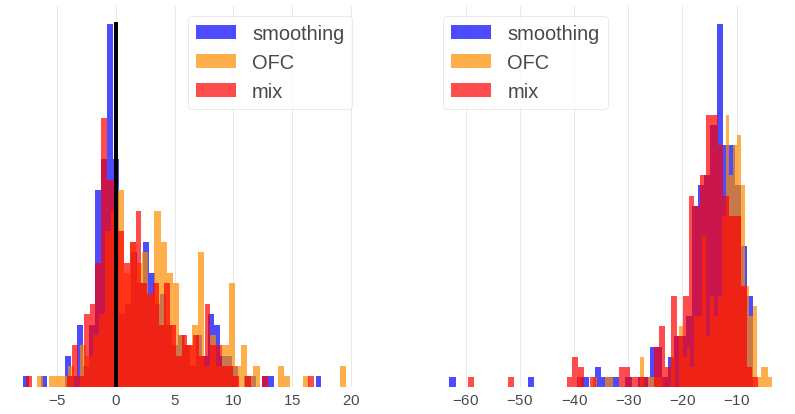

In [69]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
for exp, c, label in zip(["smoothing", "flow2d", "mix"], ["blue", "darkorange", "red"], ["smoothing", "OFC", "mix"]):
    diff_mpjpe = np.array(mpjpe_arr_per_seq[exp]) - np.array(mpjpe_arr_per_seq["init"])
    ax[0].hist(diff_mpjpe, label=label, bins=50, alpha=0.7, color=c)
    ax[0].plot([0,0], [0, 35], c='black')

    diff_accelerr = - np.array(accel_joints_err_arr_per_seq["init"]) + np.array(accel_joints_err_arr_per_seq[exp])
    ax[1].hist(diff_accelerr, label=label, bins=50, alpha=0.7, color=c)

fig.patch.set_facecolor("white")
for axis in ax: axis.legend(fontsize=20)

for axis in ax: axis.get_yaxis().set_visible(False)
for axis in ax: axis.xaxis.set_tick_params(labelsize=15)


In [128]:
np.argsort(diff_accelerr)

array([246, 202, 208,  80,   9, 197,   4, 155, 207, 205, 190, 203,   8,
       153, 154, 248,  81, 206, 116,   3, 191, 180, 204,  82, 252, 179,
        25,  65, 240, 249, 114, 175, 209, 123, 198, 221, 119, 231, 156,
       100, 183,  29, 230, 187, 124, 105,  53,  31, 196, 233, 182, 188,
        30,  26, 227,  28,  32,  20,  71,  23, 238, 181, 177, 195, 143,
       112, 239, 194, 152,  22, 113,  55, 199, 251, 125, 244,   6,  72,
       184,  99,  21, 229,  66, 121,  60, 157, 118, 107, 250,  75, 247,
       164, 122,  73,   5, 129, 245, 109, 185, 236,  96, 134, 212,  51,
       174, 222, 232, 133,  74,  61, 151, 115, 130, 178,  11, 106,  16,
        14,  46, 201,  98,  44, 220, 147,  70,  95,  52,  79,  48, 215,
        59,  54, 214, 127,  33, 189,  68, 235,  10,  27, 170,  63,  94,
       241,  77, 176,  83,  69, 243,  78,  76, 237, 228, 160, 145,  47,
        39, 108, 165, 163, 146, 213, 211,  36,  64, 218,  45, 225,  62,
        50, 186,  56, 193, 117,  19,   0,  17, 102, 171, 126,  2

In [83]:
diff_accelerr[[246, 202, 208,  80,   9, 197]], diff_mpjpe[[246, 202, 208,  80,   9, 197]]

(array([-59.64393843, -52.01938565, -40.62429005, -40.18777868,
        -40.02114396, -39.61607429]),
 array([ 6.375725 , -0.9580536, -3.0006638,  3.4706154,  7.579277 ,
        -0.8273697], dtype=float32))

In [155]:
worst_mpjpe = np.argsort(diff_mpjpe)[-4:]
print(worst_mpjpe)
print(diff_accelerr[worst_mpjpe])
print(diff_mpjpe[worst_mpjpe])

[144 103  32  56]
[-12.56973634 -11.57318729 -18.59835161 -12.93243472]
[10.125015 11.436584 12.503502 16.845005]


In [143]:
print(np.argsort(diff_accelerr)[2:7])
print(diff_accelerr[np.argsort(diff_accelerr)[2:7]])
print(diff_mpjpe[np.argsort(diff_accelerr)[2:7]])

[208  80   9 197   4]
[-40.62429005 -40.18777868 -40.02114396 -39.61607429 -38.55609036]
[-3.0006638  3.4706154  7.579277  -0.8273697  3.4522476]


array([-40.62429005, -40.18777868, -40.02114396, -39.61607429,
       -38.55609036])

In [162]:
diff_accel_err_tcmr = - np.array(accel_joints_err_arr_per_seq["init"]) + np.array(accel_joints_err_arr_per_seq["tcmr"])
diff_mpjpe_tcmr = - np.array(mpjpe_arr_per_seq["init"]) + np.array(mpjpe_arr_per_seq["tcmr"])

In [166]:
accel_better_than_tcmr = np.argsort(diff_accel_err_tcmr - diff_accelerr )[-5:][::-1]
print(accel_better_than_tcmr)
print()
print(diff_accel_err_tcmr[accel_better_than_tcmr])
print(diff_accelerr[accel_better_than_tcmr])
print()
print(diff_mpjpe_tcmr[accel_better_than_tcmr])
print(diff_mpjpe[accel_better_than_tcmr])

[122 240 228   4 222]

[ -9.56258659 -16.78939988  -9.74859614 -34.77143034 -12.43750332]
[-16.33986687 -21.86457104 -13.99394103 -38.55609036 -15.7223116 ]

[  2.3915253  -1.1544495  -0.8893318  -6.0977554 -12.960308 ]
[ 1.2705078 -2.4034424  1.8095741  3.4522476  4.222046 ]


In [ ]:
# common_name = "seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__shorter_epochs"
# common_name = "seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__lr_1e-4"
ckpt_names = {
    # "flow2d": "manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__shorter_epochs/ckpt.pth",
    # "smoothing": "manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth",
    "mix" : "seq_optim_flow__temp_smooth/seq_optim__coco-all__3dpw_test_seq_339__grid_flow2d_0.003_smooth_10/ckpt.pth",
}

device = "cuda:0"

for name, ckpt_path in ckpt_names.items():
    ckpt = torch.load(pathmgr.get_local_path(ckpt_path), map_location="cpu")["seqOpt_state_dict"]

    pose = ckpt["pose"].to(device)
    shape = ckpt["shape"].to(device)
    camera = ckpt["camera"].to(device)

    _, _, verts_all = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)

    l, r = 100, 100
    fps = 30
    num_frames = 300
    frames_out = []
    for i in tqdm(range(num_frames)):
        verts = verts_all[i].cpu().numpy()
        blend = render_verts_only(verts, faces, device)[:, l:-r]
        frames_out.append(blend)

    write_video(frames_out, f"{video_dir}verts_{name}.mp4", fps=fps)

# for name, ckpt_path in ckpt_names.items():
#     ckpt = torch.load(pathmgr.get_local_path(ckpt_path), map_location="cpu")["seqOpt_state_dict"]

#     pose = ckpt["pose"].to(device)
#     shape = ckpt["shape"].to(device)
#     camera = ckpt["camera"].to(device)

#     _, _, verts_all = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)
#     scale, trans = camera[:, 0], camera[:, 1:]
#     verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

#     l, r = 50, 50
#     frames_out = []
#     for i in tqdm(range(len(verts_all_bbox))):
#         verts = verts_all_bbox[i].cpu().numpy()
#         img = img_orig[i]
#         blend = render_mesh_onto_image(img, verts, faces, device)[:, l:-r]
#         frames_out.append(blend)

#     write_video(frames_out, f"{video_dir}Ours_{name}.mp4", fps=fps)

#     l, r = 100, 100
#     frames_out = []
#     for i in tqdm(range(len(verts_all))):
#         verts = verts_all[i].cpu().numpy()
#         blend = render_verts_only(verts, faces, device)[:, l:-r]
#         frames_out.append(blend)

#     write_video(frames_out, f"{video_dir}verts_Ours_{name}.mp4", fps=fps)

In [120]:
from src.datasets.datasets_common import UNNORMALIZE
from src.models.seq_optim import get_smpl_out
from src.utils.img_utils import convert_norm_points_to_bbox
from src.utils.vis_utils import render_mesh_onto_image
from src.utils.video_utils import write_video

In [167]:
seqs = [246, 202, 208,  80,   9, 197]  # best by accelerr
seqs = [ 65,  14, 102, 144, 103,  32,  56]  # worst by mpjpe
seqs = [122, 240, 228, 4, 222]  # better than tcmr by accel

In [168]:
savepath = "/tmp/videos_final_better_than_tcmr"
os.makedirs(savepath, exist_ok=True)


In [169]:
fps = 20

for seq in seqs:
    seqOpt = SeqModel(
        seq_path=f"/tmp/len128/seq_{seq:03d}.pth",
    ).to(device)

    img_orig = UNNORMALIZE(seqOpt.orig_seq['video']).permute(0,2,3,1).numpy()
    img_size = torch.tensor([(224, 224)]).repeat(img_orig.shape[0], 1).to(device)

    ckpt = torch.load(
        f"/tmp/seq_optim_flow_smooth_mix_len128/seq_optim__coco_all__3dpw_test_len128__flow2d_smooth__seq_{seq:03d}/ckpt.pth"
    )["seqOpt_state_dict"]

    pose_pred = ckpt["pose"].to(device)
    shape_pred = ckpt["shape"].to(device)
    camera_pred = ckpt["camera"].to(device)

    _, _, verts_all = get_smpl_out(shape_pred, pose_pred, camera_pred, smpl_model, pose2rot=True)
    scale, trans = camera_pred[:, 0], camera_pred[:, 1:]
    verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

    l, r = 50, 50
    frames_out = []
    for i in tqdm(range(len(verts_all_bbox))):
        verts = verts_all_bbox[i].cpu().numpy()
        img = img_orig[i]
        blend = render_mesh_onto_image(img, verts, faces, device)[:, l:-r]
        frames_out.append(blend)

    write_video(frames_out, f"{savepath}/seq_{seq:03d}_mix.mp4", fps=fps)

    pose_init = ckpt["pose_init"].to(device)
    shape_init = ckpt["shape_init"].to(device)
    camera_init = ckpt["camera_init"].to(device)


    _, _, verts_all = get_smpl_out(shape_init, pose_init, camera_init, smpl_model, pose2rot=True)
    scale, trans = camera_init[:, 0], camera_init[:, 1:]
    verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

    l, r = 50, 50
    frames_out = []
    for i in tqdm(range(len(verts_all_bbox))):
        verts = verts_all_bbox[i].cpu().numpy()
        img = img_orig[i]
        blend = render_mesh_onto_image(img, verts, faces, device)[:, l:-r]
        frames_out.append(blend)

    write_video(frames_out, f"{savepath}/seq_{seq:03d}_init.mp4", fps=fps)

  0%|          | 0/128 [00:00<?, ?it/s]/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/110b607930331a92/ar_sharing/body_tracking_3d/models/hmr/__bento_kernel_body_tracking__/bento_kernel_body_tracking#link-tree/pytorch3d/renderer/mesh/textures.py:324: PendingDeprecationWarning:

Textures class is deprecated,
        use TexturesUV, TexturesAtlas, TexturesVertex instead.
        Textures class will be removed in future releases.

100%|██████████| 128/128 [00:02<00:00, 47.73it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_122_mix.mp4'


100%|██████████| 128/128 [00:03<00:00, 42.32it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_122_init.mp4'


100%|██████████| 128/128 [00:02<00:00, 44.47it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_240_mix.mp4'


100%|██████████| 128/128 [00:02<00:00, 43.82it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_240_init.mp4'


100%|██████████| 128/128 [00:02<00:00, 42.84it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_228_mix.mp4'


100%|██████████| 128/128 [00:02<00:00, 45.30it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_228_init.mp4'


100%|██████████| 128/128 [00:02<00:00, 43.69it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_004_mix.mp4'


100%|██████████| 128/128 [00:03<00:00, 41.18it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_004_init.mp4'


100%|██████████| 128/128 [00:02<00:00, 48.75it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_222_mix.mp4'


100%|██████████| 128/128 [00:03<00:00, 42.26it/s]


Video is saved to '/tmp/videos_final_better_than_tcmr/seq_222_init.mp4'


In [170]:
from src.utils.video_utils import get_frames, write_video, write_video_gif

for seq in seqs:
    video_paths = [
        f"/tmp/videos_final_better_than_tcmr/seq_{seq:03d}_init.mp4",
        f"/tmp/videos_final_better_than_tcmr/seq_{seq:03d}_mix.mp4",
    ]

    vid_frames = []
    for vid_path in video_paths:
        frame_list, _ = get_frames(pathmgr.get_local_path(vid_path), scale=2)
        vid_frames.append(frame_list)

    num_frames = len(frame_list)

    out_frames = []
    for frame_idx in range(num_frames):
        out_frame = np.concatenate(
            (
                vid_frames[0][frame_idx],
                vid_frames[1][frame_idx],
            ),
            axis=1,
        )
        out_frames.append(out_frame)

    write_video(out_frames, f"/tmp/videos_final_better_than_tcmr/concat_init_mix_{seq:03d}.mp4", fps=fps)

Video is saved to '/tmp/videos_final_better_than_tcmr/concat_init_mix_122.mp4'


Video is saved to '/tmp/videos_final_better_than_tcmr/concat_init_mix_240.mp4'


Video is saved to '/tmp/videos_final_better_than_tcmr/concat_init_mix_228.mp4'


Video is saved to '/tmp/videos_final_better_than_tcmr/concat_init_mix_004.mp4'


Video is saved to '/tmp/videos_final_better_than_tcmr/concat_init_mix_222.mp4'
